In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage import measure, io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug
import visualization as viz
from training_utilities import TrainingMetrics, TrainingTimer
import glob
from astropy.io import fits
from random import randint
import matplotlib.pyplot as plt


In [2]:
train_images_list = glob.glob('../Results/LWIRISEG/Results/*Train*.fits')
val_images_list = glob.glob('../Results/LWIRISEG/Results/*Val*.fits')
print(len(train_images_list))
print(len(val_images_list))
train_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in train_images_list]
val_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in val_images_list]

200
200


In [8]:
def binarize_image(img,pred):
    img_thresh = threshold_otsu(img)
    pred_thresh = threshold_otsu(pred)

    img_binary = img > img_thresh
    pred_binary = pred > pred_thresh

    return  img_binary, pred_binary

def count_blob(img):
    labels = measure.label(img, background=0)
    return labels.max()

def count_blobs(image_tuple,return_count_only=False):
    img , mask, pred = image_tuple
    img_binary, pred_binary = binarize_image(img, pred)
    # Label the connected regions in the image
    img_bin_count = count_blob(img_binary)
    pred_binary_count = count_blob(pred_binary)
    mask_count = count_blob(mask)
    #
    img_count = count_blob(img)
    pred_count = count_blob(pred)

    if return_count_only:
        return img_bin_count,mask_count,pred_binary_count
    else:
    # The maximum label number is the count of blobs
        return f"Count : Image bin {img_bin_count}, Pred bin {pred_binary_count}, Mask {mask_count}, Image {img_count}, Pred {pred_count}" 

def compute_quality(binary_image):
    # Example metric: total area of clouds to the area of the sky
    img_bin_labels = measure.label(binary_image, background=0)
    regions = measure.regionprops(img_bin_labels)
    cloud_area = np.sum([region.area for region in regions])
    return cloud_area / binary_image.size

def quantify_sky_quality(image_tuple):
    img , mask, pred = image_tuple
    img_binary, pred_binary = binarize_image(img, pred)
    # Label the connected regions in the image
    sq_img_bin  = compute_quality(img_binary)
    sq_mask     = compute_quality(mask)
    sq_pred_bin = compute_quality(pred_binary)
    sq_img      = compute_quality(img)
    sq_pred     = compute_quality(pred)
    
    return f"SQ : Image bin {sq_img_bin}, Pred bin {sq_mask}, Mask {sq_pred_bin}, Image {sq_img}, Pred {sq_pred}" 



In [12]:
#funct = count_blob
funct = count_blobs
indx = 0

Indx 0 counts Count : Image bin 20, Pred bin 4, Mask 1, Image 0, Pred 0
Indx 1 counts Count : Image bin 4, Pred bin 20, Mask 37, Image 0, Pred 0
Indx 2 counts Count : Image bin 33, Pred bin 1, Mask 5, Image 0, Pred 0
Indx 3 counts Count : Image bin 3, Pred bin 1, Mask 2, Image 0, Pred 0
Indx 4 counts Count : Image bin 4, Pred bin 2, Mask 1, Image 0, Pred 1


/home/wassim/Project/infrared-cloud-detection/notebooks/../utilities/visualization.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


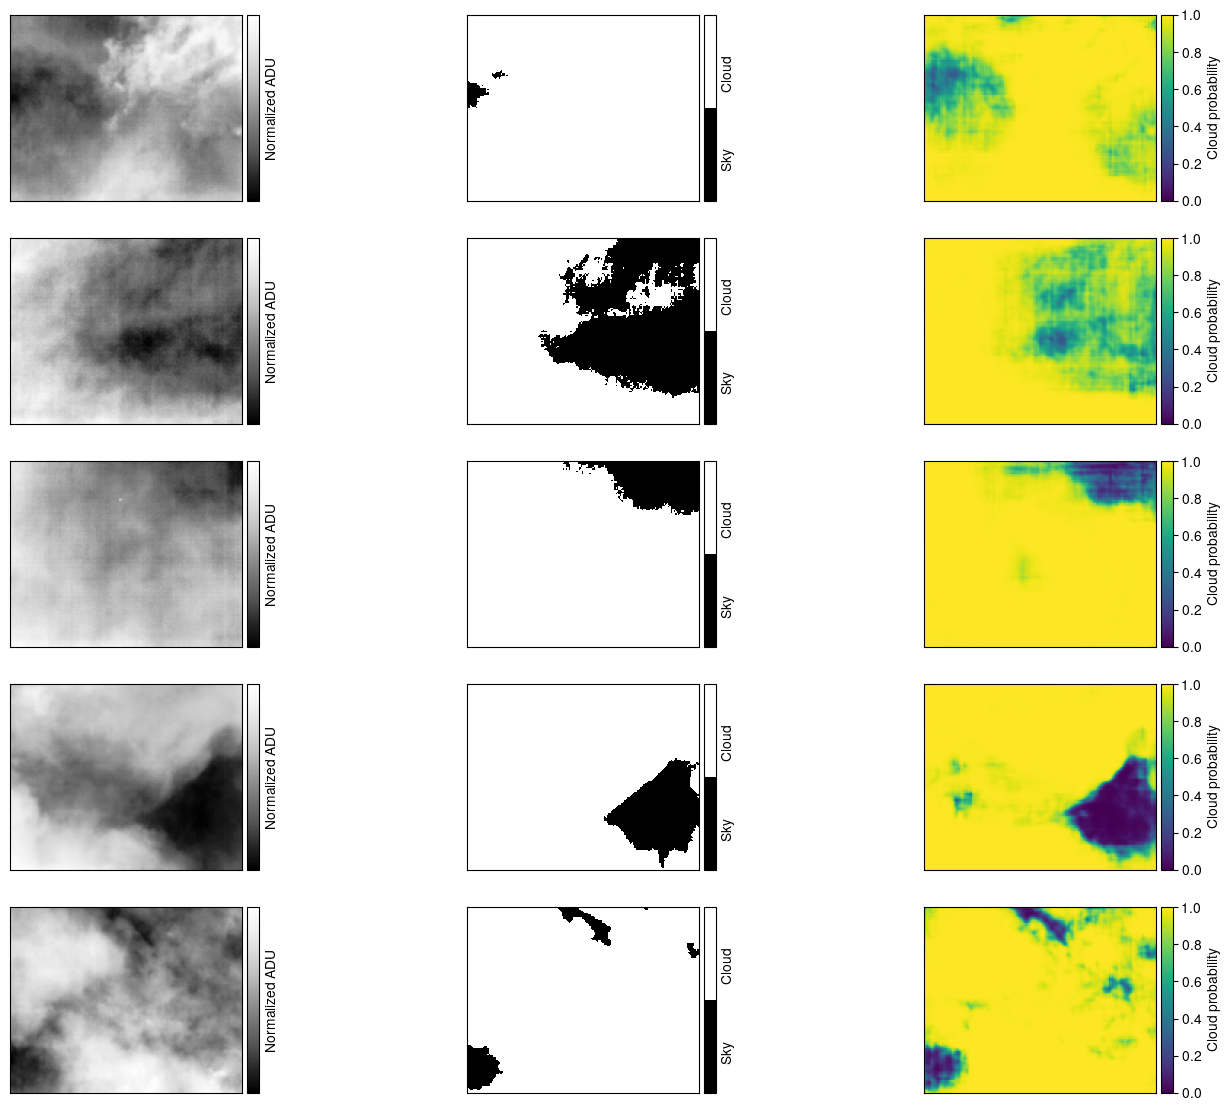

In [9]:
indx = indx + 1
nb = indx*5
print(f"Indx {nb-5} counts {funct(train_fits[nb-5])}")
print(f"Indx {nb-4} counts {funct(train_fits[nb-4])}")
print(f"Indx {nb-3} counts {funct(train_fits[nb-3])}")
print(f"Indx {nb-2} counts {funct(train_fits[nb-2])}")
print(f"Indx {nb-1} counts {funct(train_fits[nb-1])}")
viz.plot_image_preds(train_fits[nb-5:nb],figsize_per_row=(16,14), output_path=None)


/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/notebooks/../utilities/visualization.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


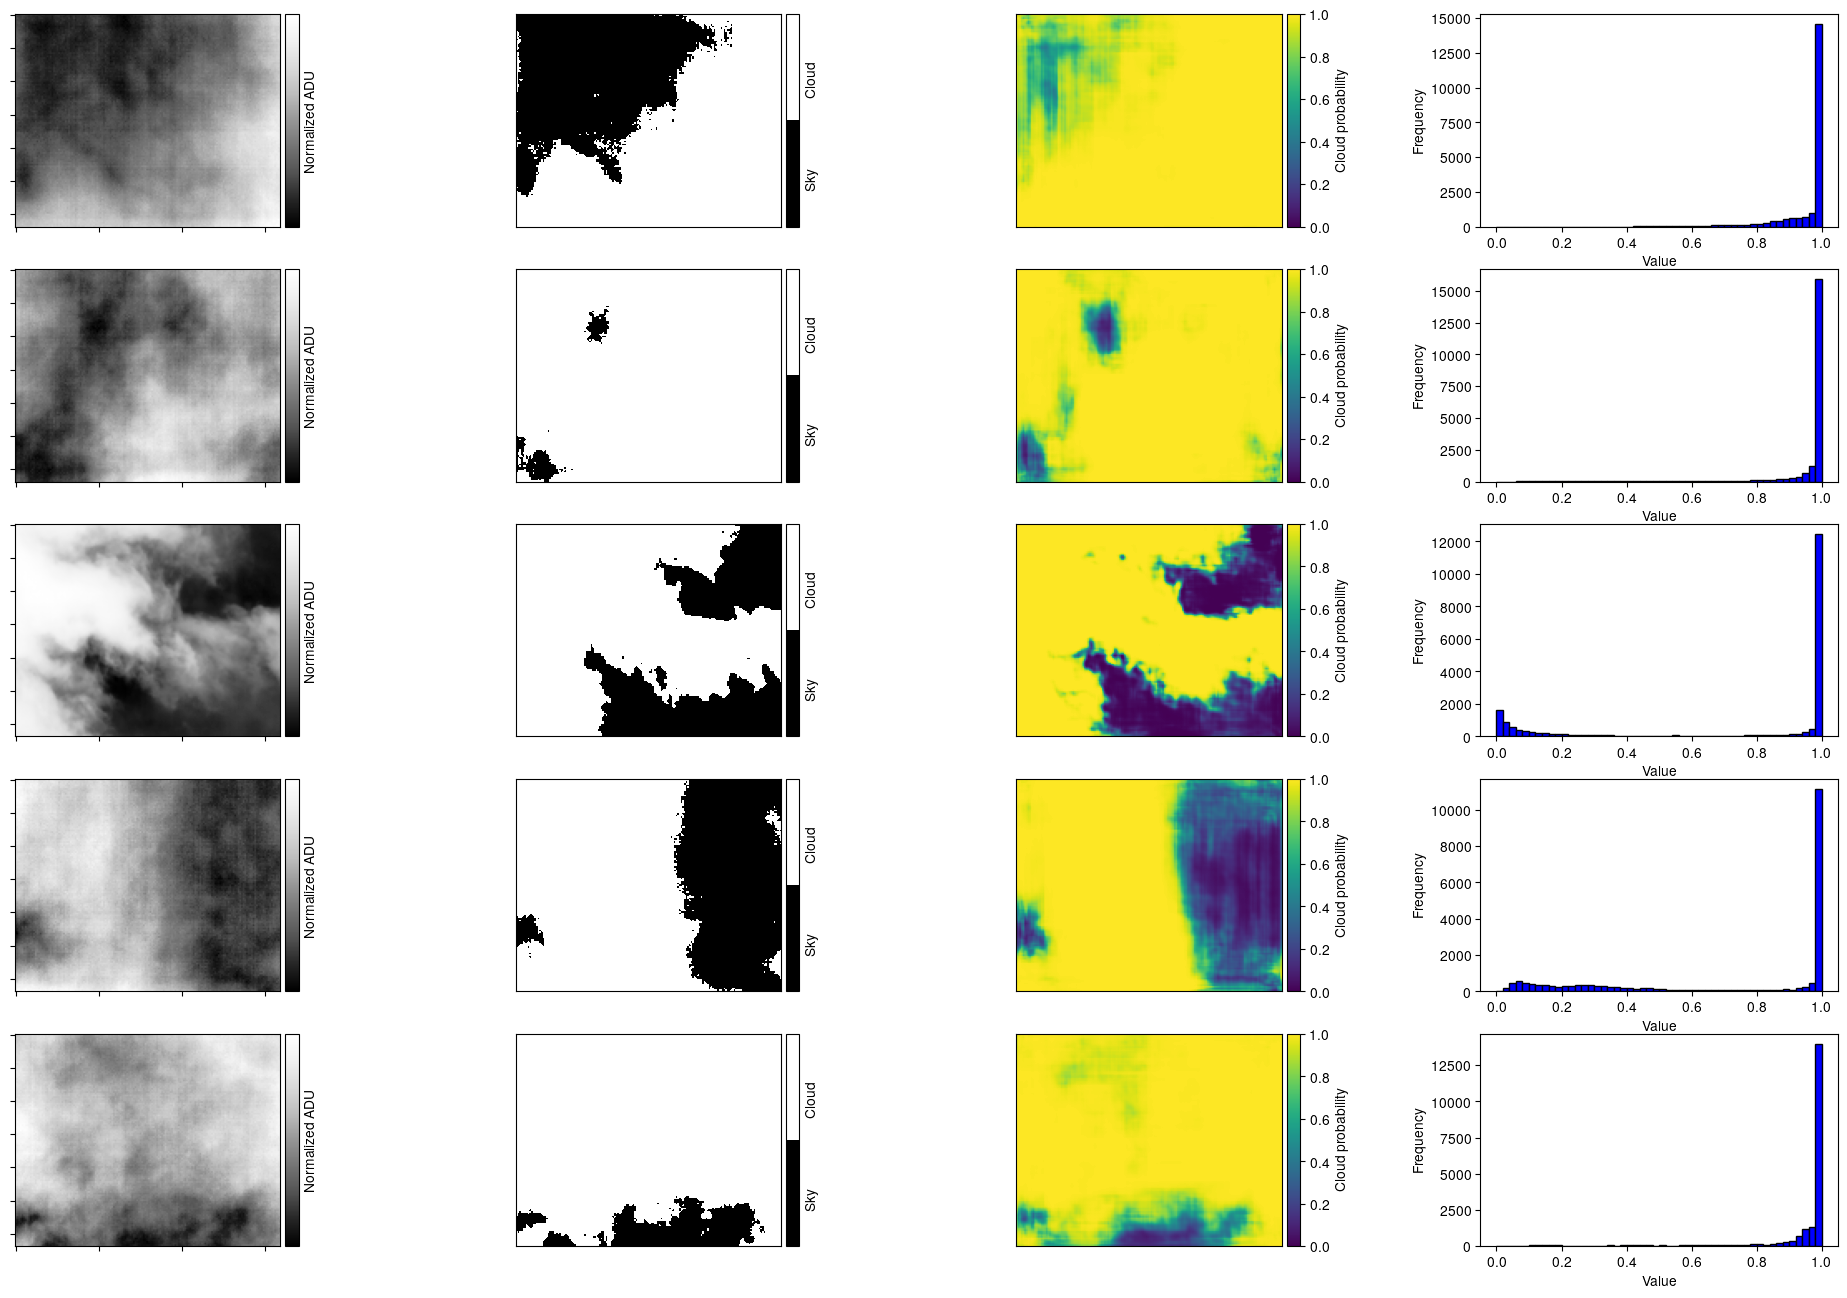

In [6]:
viz.plot_image_preds(data_list=[train_fits[4], train_fits[189], train_fits[171],train_fits[181],train_fits[17]],figsize_per_row=(24,16),predmask_cmap='viridis', output_path=None, include_histogram=True)

Indx 42 counts Count : Image bin 10, Pred bin 4, Mask 8, Image 0, Pred 15
Indx 46 counts Count : Image bin 7, Pred bin 3, Mask 2, Image 0, Pred 14
Indx 53 counts Count : Image bin 15, Pred bin 11, Mask 16, Image 0, Pred 0

Indx 46 counts Count : Image bin 7, Pred bin 3, Mask 2, Image 0, Pred 14
Indx 42 counts Count : Image bin 10, Pred bin 4, Mask 8, Image 0, Pred 15
Indx 53 counts Count : Image bin 15, Pred bin 11, Mask 16, Image 0, Pred 0


/home/wassim/Project/infrared-cloud-detection/notebooks/../utilities/visualization.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


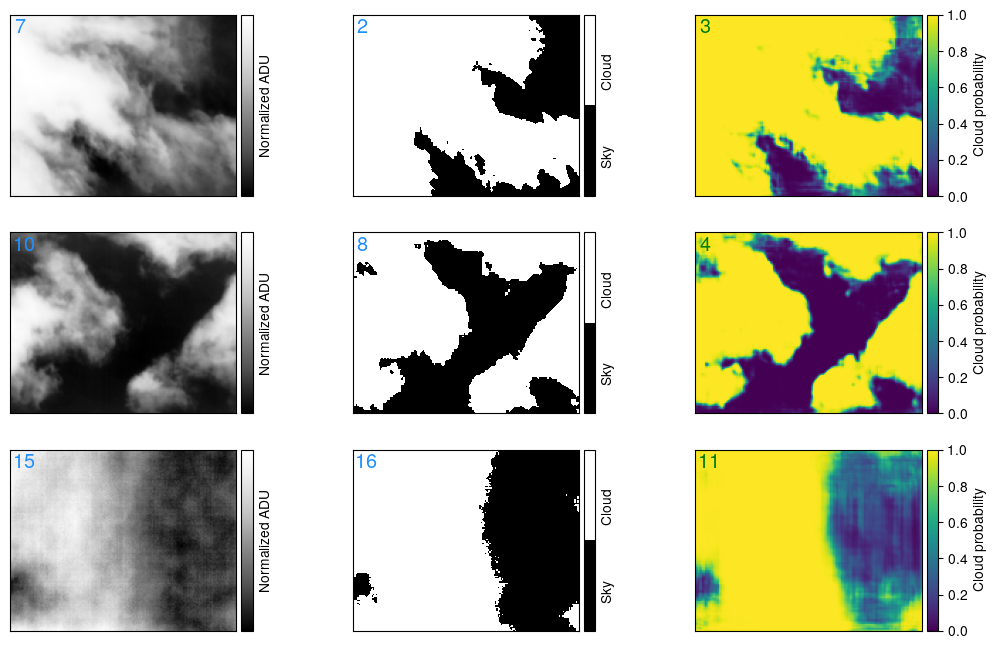

In [21]:
print(f"Indx {46} counts {funct(train_fits[46])}")
print(f"Indx {42} counts {funct(train_fits[42])}")
print(f"Indx {53} counts {funct(train_fits[53])}")
tuple_list = [funct(train_fits[46],True),funct(train_fits[42],True),funct(train_fits[53],True)]
viz.plot_image_preds([train_fits[46],train_fits[42],train_fits[53]],figsize_per_row=(12,8), output_path='sampleblobc.pdf',blob_tuple_list=tuple_list)